In [3]:
import snap
from os import path
import pickle
import collections
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import random

In [4]:
BASE_PATH = "../data/stats.stackexchange.com/Mixed"
FOLDED_NGRAM_GRAPH_PATH = path.join(BASE_PATH, "Userid_Ngram_Folded_Graph.graph")
FOLDED_POSTID_GRAPH_PATH = path.join(BASE_PATH, "Postid_Folded_Graph.graph")
NGRAM_DICT_PICKLE = path.join(BASE_PATH, "Bigramid_Dict")
POSTID_PICKLE = path.join(BASE_PATH, "STATS_20k-Posts_11-top_uni&bigrams_nostem.pickle")
POST_TOP_NGRAM_PATH = path.join(BASE_PATH, "STATS_20k-Posts_11-top_uni&bigrams_nostem.tsv")
COMMUNITIES_PATH = path.join(BASE_PATH, 'postid-communities-with-postbodies.txt')
COMMUNITIES_VEC_PATH = path.join(BASE_PATH, 'postid-communities.vector')
EDGELIST_PATH = path.join(BASE_PATH, 'postid_edges.txt')
COMMUNITIES_VIZ_PATH = path.join(BASE_PATH, 'postid-communities-viz.csv')
COMMUNITIES_VIZ_PATH2 = path.join(BASE_PATH, 'postid-spectral-communities-viz.csv')
SPEC_COMMUNITIES_PICKLE = path.join(BASE_PATH, 'Spectral_Node_to_Community_dict.pickle')
CNM_COMMUNITIES_PICKLE = path.join(BASE_PATH, 'CNM_Node_to_Community_dict.pickle')

In [5]:
def get_modularity(G, community_dict):
    two_M = G.GetEdges() * 2.0
    mod_sum = 0.0
    for NI in G.Nodes():
        NI_id = NI.GetId()
        for NJ in G.Nodes():
            NJ_id = NJ.GetId()
            if (community_dict[NI_id] == community_dict[NJ_id]):
                mod_sum += G.IsEdge(NI_id, NJ_id) - ((NI.GetDeg() * NJ.GetDeg()) / two_M)
    modularity = mod_sum / two_M
    return modularity

def load_top_ngram_df(topwords_path):
    # Load csv containing the top words.
    posts_df = pd.read_csv(topwords_path, sep = "\t", usecols =
                           ["Id", "OwnerUserId", "TopWord1", "TopWord2", "TopWord3", "TopWord4", "TopWord5"])

    # Clean dataframe.
    posts_df = posts_df.dropna()
    posts_df = posts_df.rename(columns={
            "Id": "post_id", "OwnerUserId": "user_id"})
    posts_df["user_id"] = posts_df["user_id"].astype(np.int64)
    posts_df["post_id"] = posts_df["post_id"].astype(np.int64)
    posts_df = posts_df[posts_df["user_id"] > 0]
    posts_df = posts_df[posts_df["post_id"] > 0]

    return posts_df

def add_communities_post_df(post_df, best_comm_map, postid_dict):
    # Iterate over rows and add each community to each row.
    community_array = []
    for index, row in post_df.iterrows():
        user_id = row["post_id"]
        A_id = postid_dict.get(user_id, -1)
        if (A_id < 0):
            community_array.append(-1)
        else:
            community_array.append(best_comm_map[A_id])
    post_df.loc[:,'Community'] = community_array

    return post_df

In [6]:
f_in = snap.TFIn(FOLDED_POSTID_GRAPH_PATH)
post_graph = snap.TUNGraph.Load(f_in)
print "original nodes", post_graph.GetNodes()
print "edges", post_graph.GetEdges()
assert snap.CntSelfEdges(post_graph) == 0
snap.DelZeroDegNodes(post_graph)
print "new nodes (no degree-0)", post_graph.GetNodes()

original nodes 19725
edges 567729
new nodes (no degree-0) 17139


In [7]:
comm_vec = snap.TCnComV()
modularity = snap.CommunityCNM(post_graph, comm_vec)

print "modularity", modularity

f_out = snap.TFOut(COMMUNITIES_VEC_PATH)
comm_vec.Save(f_out)
f_out.Flush()

modularity 0.441618294539


In [8]:
f_in = snap.TFIn(COMMUNITIES_VEC_PATH)
comm_vec = snap.TCnComV()
comm_vec.Load(f_in)

print "communities", len(comm_vec)

communities 66


In [9]:
pickle_file = open(POSTID_PICKLE, 'rb')
postid_dict = pickle.load(pickle_file)

community_dict = collections.defaultdict(int)

with open(COMMUNITIES_PATH, 'w') as f:
    for i, comm in enumerate(comm_vec):
        f.write("#####Community {}#####\n".format(i))
        community = snap.TIntV()
        for node in comm:
            community.Add(node)
#             f.write("Node {}: {}\n".format(node, postid_dict[node]))
            community_dict[node] = i
        f.write('Community {}, nodes: {} modularity: {}\n'.format(i, len(comm), snap.GetModularity(post_graph, community, post_graph.GetEdges())))
    f.write("The modularity of the network is {}\n".format(modularity))
    alt_modularity = get_modularity(post_graph, community_dict)
    f.write("Alternate modularity of the network (sanity check) is {}".format(alt_modularity))

In [10]:
postid_dict2 = collections.defaultdict(int)
for node in community_dict:
    postid_dict2[node] = node

post_df = load_top_ngram_df(POST_TOP_NGRAM_PATH)
post_df_w_comm = add_communities_post_df(post_df, community_dict, postid_dict2)

In [11]:
communities = set(post_df_w_comm["Community"])
for comm in communities:
    print "Community:", comm, "Size:", len(post_df[post_df_w_comm["Community"] == comm])

Community: 0 Size: 4030
Community: 1 Size: 2303
Community: 2 Size: 24
Community: 3 Size: 4711
Community: 4 Size: 5343
Community: 5 Size: 97
Community: 6 Size: 4
Community: 7 Size: 5
Community: 8 Size: 159
Community: 9 Size: 127
Community: 10 Size: 2
Community: 11 Size: 4
Community: 12 Size: 9
Community: 13 Size: 36
Community: 14 Size: 4
Community: 15 Size: 9
Community: 16 Size: 2
Community: 17 Size: 46
Community: 18 Size: 3
Community: 19 Size: 8
Community: 20 Size: 2
Community: 21 Size: 7
Community: 22 Size: 55
Community: 23 Size: 4
Community: 24 Size: 4
Community: 25 Size: 3
Community: 26 Size: 4
Community: 27 Size: 5
Community: 28 Size: 10
Community: 29 Size: 17
Community: 30 Size: 4
Community: 31 Size: 8
Community: 32 Size: 12
Community: 33 Size: 2
Community: 34 Size: 2
Community: 35 Size: 2
Community: 36 Size: 4
Community: 37 Size: 4
Community: 38 Size: 2
Community: 39 Size: 5
Community: 40 Size: 2
Community: 41 Size: 2
Community: 42 Size: 3
Community: 43 Size: 2
Community: 44 Size

In [41]:
post_df[post_df_w_comm["Community"] == 9]

,post_id,user_id,TopWord1,TopWord2,TopWord3,TopWord4,TopWord5,Community
86,317812,140340,graphs,acyclic directed,art estimating,cycles current,described likely,9
307,318082,10278,architecture,reinforcement learning,reinforcement,learning,24x24,9
474,318311,152805,ordinate,elbow,elbow point,drops,value ordinate,9
564,318423,46427,texts,author,learning,author texts,berger extremely,9
1064,319061,83134,bus,observe process,having seen,long,minutes,9
1120,319130,119749,hardness,learning,deep learning,deep,non informative,9
1422,319532,17908,principled,science,learning,able technologies,build ships,9
1453,319569,53690,optimizer,checking help,file function,help file,file,9
1463,319581,30834,adam,optimizer,accuracies say,accuracy nearly,adam popular,9
1514,319650,187209,graphs,asset,asset classes,having graphs,make report,9


In [13]:
snap.SaveEdgeList(post_graph, EDGELIST_PATH)

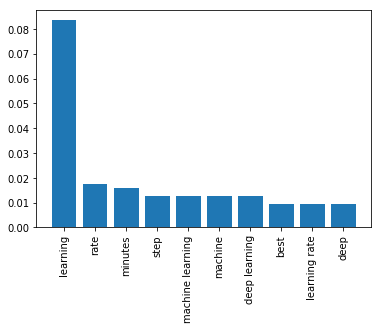

In [46]:
# word frequency in communities
word_counts = collections.defaultdict(dict)
word_freqs = collections.defaultdict(dict)
for comm in communities:
    total_words = 0.0
    word_counts[comm] = collections.defaultdict(int)
    for word in post_df_w_comm[post_df_w_comm["Community"] == comm]['TopWord1']:
        word_counts[comm][word] += 1
        total_words += 1
    for word in post_df_w_comm[post_df_w_comm["Community"] == comm]['TopWord2']:
        word_counts[comm][word] += 1
        total_words += 1
    for word in post_df_w_comm[post_df_w_comm["Community"] == comm]['TopWord3']:
        word_counts[comm][word] += 1
        total_words += 1
    for word in post_df_w_comm[post_df_w_comm["Community"] == comm]['TopWord4']:
        word_counts[comm][word] += 1
        total_words += 1
    for word in post_df_w_comm[post_df_w_comm["Community"] == comm]['TopWord5']:
        word_counts[comm][word] += 1
        total_words += 1
    for word in word_counts[comm]:
        word_freqs[comm][word] = word_counts[comm][word] / total_words
   
sorted_word_freqs = collections.defaultdict(dict)
for comm in word_freqs:
    sorted_word_freqs[comm] = sorted(word_freqs[comm].items(), key=lambda x: x[1], reverse=True)

COMM_TERMS = 9
y_pos = []
x_labels = []
for word in sorted_word_freqs[COMM_TERMS][:10]:
    y_pos.append(word[1])
    x_labels.append(word[0])
    
plt.bar(x_labels, y_pos)
plt.xticks(rotation=90)
plt.show()

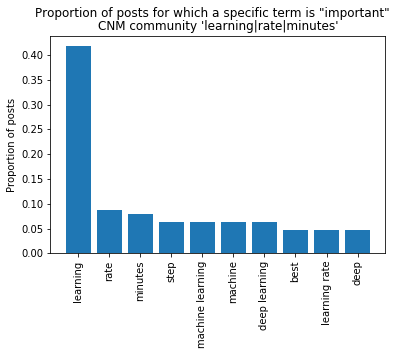

In [61]:
# word frequency in communities
word_counts = collections.defaultdict(dict)
word_freqs = collections.defaultdict(dict)
for comm in communities:
    total_rows = 0.0
    word_counts[comm] = collections.defaultdict(int)
    for word in post_df_w_comm[post_df_w_comm["Community"] == comm]['TopWord1']:
        word_counts[comm][word] += 1
        total_rows += 1
    for word in post_df_w_comm[post_df_w_comm["Community"] == comm]['TopWord2']:
        word_counts[comm][word] += 1
    for word in post_df_w_comm[post_df_w_comm["Community"] == comm]['TopWord3']:
        word_counts[comm][word] += 1
    for word in post_df_w_comm[post_df_w_comm["Community"] == comm]['TopWord4']:
        word_counts[comm][word] += 1
    for word in post_df_w_comm[post_df_w_comm["Community"] == comm]['TopWord5']:
        word_counts[comm][word] += 1
    for word in word_counts[comm]:
        word_freqs[comm][word] = word_counts[comm][word] / total_rows
        
sorted_word_freqs = collections.defaultdict(dict)
for comm in word_freqs:
    sorted_word_freqs[comm] = sorted(word_freqs[comm].items(), key=lambda x: x[1], reverse=True)

COMM_TERMS = 9
y_pos = []
x_labels = []
for word in sorted_word_freqs[COMM_TERMS][:10]:
    y_pos.append(word[1])
    x_labels.append(word[0])
    
plt.bar(x_labels, y_pos)
plt.xticks(rotation=90)
plt.ylabel("Proportion of posts")
plt.title("CNM community 'learning|rate|minutes'")
plt.suptitle('Proportion of posts for which a specific term is "important"')
plt.savefig('cnm_proportion.png')

In [21]:
sorted_word_freqs = collections.defaultdict(dict)
for comm in word_freqs:
    sorted_word_freqs[comm] = sorted(word_freqs[comm].items(), key=lambda x: x[1], reverse=True)

community_labels = collections.defaultdict(str) 

for ind, comm in enumerate(sorted_word_freqs):
    community_labels[comm] = "{}|{}|{}".format(sorted_word_freqs[comm][0][0], sorted_word_freqs[comm][1][0], sorted_word_freqs[comm][2][0])

rankings = []

for comm in communities:
    if comm == -1: continue
#     print "Community: {:3}  Size: {:5}  Proportion: {:.8f}  Label: {}".format(comm, len(post_df[post_df_w_comm["Community"] == comm]), len(post_df[post_df_w_comm["Community"] == comm]) / float(len(post_df)), community_labels[comm])
    rankings.append((comm, len(post_df[post_df_w_comm["Community"] == comm]), 100.0 * len(post_df[post_df_w_comm["Community"] == comm]) / len(post_df), community_labels[comm]))
    
rankings.sort(key=lambda x: x[2], reverse = True)
rankings

[(4, 5343, 27.08745247148289, 'series|time|group'),
 (3, 4711, 23.88339670468948, 'test|training|validation'),
 (0, 4030, 20.430925221799747, 'distribution|sample|probability'),
 (1, 2303, 11.67553865652725, 'matrix|model|variables'),
 (8, 159, 0.8060836501901141, 'size|power|uncertainty'),
 (9, 127, 0.6438529784537389, 'learning|rate|minutes'),
 (5, 97, 0.4917617237008872, 'outliers|bias|percentile'),
 (22, 55, 0.2788339670468948, 'lt|gt|gt gt'),
 (17, 46, 0.2332065906210393, 'inequality|code|money'),
 (13, 36, 0.18250950570342206, 'sensitivity|specificity|cut'),
 (2, 24, 0.12167300380228137, 'pattern|sklearn|truck'),
 (29, 17, 0.08618504435994931, 'table|holt winters|winters'),
 (32, 12, 0.060836501901140684, 'question|invertible|dgp'),
 (28, 10, 0.050697084917617236, 'near|plm|popularity'),
 (12, 9, 0.045627376425855515, 'count data|count|data time'),
 (15, 9, 0.045627376425855515, 'concentration|flow|water'),
 (19, 8, 0.04055766793409379, 'populations|performing|phenotype'),
 (31, 

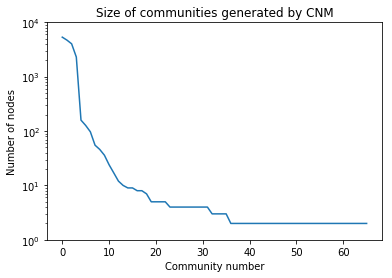

In [22]:
# plots

y_pos = []
x_labels = []
for comm in communities:
    if comm == -1: continue
    y_pos.append(len(post_df[post_df_w_comm["Community"] == comm]))
#     x_labels.append("{}: {}".format(comm, community_labels[comm]))
    x_labels.append(community_labels[comm])

y_pos, x_labels = zip(*sorted(zip(y_pos, x_labels), reverse=True))

plt.plot(y_pos)
plt.title("Size of communities generated by CNM")
plt.ylabel("Number of nodes")
plt.yscale('log')
plt.ylim((1,10000))
plt.xlabel("Community number")
plt.savefig('cnm_community_size.png')

In [23]:
post_df_w_comm.to_csv(COMMUNITIES_VIZ_PATH, encoding='utf-8', index=False, columns = ['post_id', 'Community'])
post_df_w_comm

,post_id,user_id,TopWord1,TopWord2,TopWord3,TopWord4,TopWord5,Community
0,317697,134975,variables statistically,mixed effect,mixed,variables,statistically significant,1
1,317699,45374,accuracy,validation accuracy,training accuracy,shallow,validation,3
2,317701,171235,freedom,mean,degrees freedom,degrees,data degree,0
3,317703,187797,patients,treating,excel,treat,bias treating,4
4,317704,61496,uncertainty,error ways,estimate realistic,forecast method,predicts time,8
5,317705,134369,bonferroni correction,bonferroni,correction,outliers,don understand,4
6,317707,187792,environmental variables,traits,environmental,plant traits,plant,1
7,317708,82816,solve differential,equation distribution,differential equation,need solve,distribution pdf,0
8,317710,61092,monotonically increasing,monotonically,differentiable,increasing,assuming differentiable,0
9,317711,179343,affect specified,shock affect,understand shock,prof,shock,4


In [24]:
# spectral clustering
pickle_f = open(SPEC_COMMUNITIES_PICKLE, 'rb')
community_dict2 = pickle.load(pickle_f)
pickle_f.close()

community_dict2

{0: 1,
 1: 1,
 2: 74,
 3: 78,
 4: 106,
 5: 1,
 6: 99,
 7: 1,
 8: 78,
 9: 1,
 10: 111,
 11: 83,
 12: 17,
 13: 61,
 14: 133,
 15: 1,
 16: 93,
 17: 118,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 56,
 23: 118,
 24: 118,
 25: 102,
 26: 1,
 27: 1,
 28: 118,
 29: 118,
 30: 126,
 31: 1,
 32: 1,
 33: 50,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 66,
 41: 1,
 42: 1,
 43: 66,
 44: 1,
 45: 1,
 46: 16,
 47: 147,
 48: 122,
 49: 143,
 50: 58,
 51: 1,
 52: 1,
 53: 119,
 54: 1,
 55: 1,
 56: 1,
 57: 130,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 96,
 65: 129,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 61,
 72: 77,
 73: 118,
 74: 117,
 75: 1,
 76: 145,
 77: 1,
 78: 135,
 79: 1,
 80: 72,
 81: 118,
 82: 1,
 83: 68,
 84: 1,
 85: 1,
 86: 1,
 87: 54,
 88: 58,
 89: 1,
 90: 1,
 91: 1,
 92: 1,
 93: 137,
 94: 1,
 95: 111,
 96: 66,
 97: 1,
 98: 121,
 99: 1,
 100: 1,
 101: 106,
 102: 1,
 103: 1,
 104: 1,
 105: 101,
 106: 1,
 107: 109,
 108: 1,
 109: 118,
 110: 69,
 111: 137,
 112: 130,
 113: 1,
 

In [25]:
def remap_postids(G):
    """
    Returns a Graph containing all the remapped post_ids so that they go from 0 to n. 
    Also returns the dictionary that maps the ids to their new value.
    """
    postid_map = dict()
    new_G = snap.TUNGraph.New()
    index = 0
    
    # Remap all nodes. Only keep ones with degree > 0.
    for N in G.Nodes():
        if (N.GetDeg() < 1): continue 
        postid_map[N.GetId()] = index
        new_G.AddNode(index)
        index += 1
                
    # Remap all edges.
    for E in G.Edges(): # Edge traversal
        new_G.AddEdge(postid_map[E.GetSrcNId()], postid_map[E.GetDstNId()])
        
    return new_G, postid_map

In [26]:
_, postid_dict2 = remap_postids(post_graph)

post_df2 = load_top_ngram_df(POST_TOP_NGRAM_PATH)
post_df_w_comm2 = add_communities_post_df(post_df2, community_dict2, postid_dict2)

In [27]:
post_df_w_comm2

,post_id,user_id,TopWord1,TopWord2,TopWord3,TopWord4,TopWord5,Community
0,317697,134975,variables statistically,mixed effect,mixed,variables,statistically significant,42
1,317699,45374,accuracy,validation accuracy,training accuracy,shallow,validation,145
2,317701,171235,freedom,mean,degrees freedom,degrees,data degree,140
3,317703,187797,patients,treating,excel,treat,bias treating,1
4,317704,61496,uncertainty,error ways,estimate realistic,forecast method,predicts time,1
5,317705,134369,bonferroni correction,bonferroni,correction,outliers,don understand,120
6,317707,187792,environmental variables,traits,environmental,plant traits,plant,92
7,317708,82816,solve differential,equation distribution,differential equation,need solve,distribution pdf,1
8,317710,61092,monotonically increasing,monotonically,differentiable,increasing,assuming differentiable,1
9,317711,179343,affect specified,shock affect,understand shock,prof,shock,1


In [28]:
communities2 = set(post_df_w_comm2["Community"])
for comm in communities2:
    print "Community:", comm, "Size:", len(post_df2[post_df_w_comm2["Community"] == comm])

Community: 0 Size: 87
Community: 1 Size: 8343
Community: 2 Size: 2
Community: 3 Size: 2
Community: 4 Size: 2
Community: 5 Size: 2
Community: 6 Size: 2
Community: 7 Size: 2
Community: 8 Size: 2
Community: 9 Size: 2
Community: 10 Size: 2
Community: 11 Size: 2
Community: 12 Size: 2
Community: 13 Size: 2
Community: 14 Size: 2
Community: 15 Size: 3
Community: 16 Size: 169
Community: 17 Size: 200
Community: 18 Size: 8
Community: 19 Size: 7
Community: 20 Size: 2
Community: 21 Size: 2
Community: 22 Size: 2
Community: 23 Size: 4
Community: 24 Size: 2
Community: 25 Size: 2
Community: 26 Size: 5
Community: 27 Size: 2
Community: 28 Size: 2
Community: 29 Size: 2
Community: 30 Size: 29
Community: 31 Size: 2
Community: 32 Size: 4
Community: 33 Size: 5
Community: 34 Size: 2
Community: 35 Size: 3
Community: 36 Size: 2
Community: 37 Size: 2
Community: 38 Size: 6
Community: 39 Size: 2
Community: 40 Size: 2
Community: 41 Size: 2
Community: 42 Size: 109
Community: 43 Size: 65
Community: 44 Size: 2
Communit

In [29]:
# word frequency in communities2
word_counts2 = collections.defaultdict(dict)
word_freqs2 = collections.defaultdict(dict)
for comm in communities2:
    total_words = 0.0
    word_counts2[comm] = collections.defaultdict(int)
    for word in post_df_w_comm2[post_df_w_comm2["Community"] == comm]['TopWord1']:
        word_counts2[comm][word] += 1
        total_words += 1
    for word in post_df_w_comm2[post_df_w_comm2["Community"] == comm]['TopWord2']:
        word_counts2[comm][word] += 1
        total_words += 1
    for word in post_df_w_comm2[post_df_w_comm2["Community"] == comm]['TopWord3']:
        word_counts2[comm][word] += 1
        total_words += 1
    for word in post_df_w_comm2[post_df_w_comm2["Community"] == comm]['TopWord4']:
        word_counts2[comm][word] += 1
        total_words += 1
    for word in post_df_w_comm2[post_df_w_comm2["Community"] == comm]['TopWord5']:
        word_counts2[comm][word] += 1
        total_words += 1
    for word in word_counts2[comm]:
        word_freqs2[comm][word] = word_counts2[comm][word] / total_words

In [30]:
sorted_word_freqs2 = collections.defaultdict(dict)
for comm in word_freqs2:
    sorted_word_freqs2[comm] = sorted(word_freqs2[comm].items(), key=lambda x: x[1], reverse=True)

community_labels2 = collections.defaultdict(str) 

for ind, comm in enumerate(sorted_word_freqs2):
    community_labels2[comm] = "{}|{}|{}".format(sorted_word_freqs2[comm][0][0], sorted_word_freqs2[comm][1][0], sorted_word_freqs2[comm][2][0])

# for comm in communities2:
#     print "Community: {:3}  Size: {:5}  Label: {}".format(comm, len(post_df[post_df_w_comm2["Community"] == comm]), community_labels2[comm])
    
rankings2 = []

for comm in communities2:
    if comm == -1: continue
#     print "Community: {:3}  Size: {:5}  Proportion: {:.8f}  Label: {}".format(comm, len(post_df[post_df_w_comm["Community"] == comm]), len(post_df[post_df_w_comm["Community"] == comm]) / float(len(post_df)), community_labels[comm])
    rankings2.append((comm, len(post_df2[post_df_w_comm2["Community"] == comm]), 100.0 * len(post_df2[post_df_w_comm2["Community"] == comm]) / len(post_df2), community_labels2[comm]))
    
rankings2.sort(key=lambda x: x[2], reverse = True)
rankings2

[(1, 8343, 42.29657794676806, 'feature|dataset|value'),
 (118, 1037, 5.257287705956908, 'density|normal|parameter'),
 (145, 301, 1.525982256020279, 'training|validation|data'),
 (102, 246, 1.247148288973384, 'network|cost|event'),
 (50, 222, 1.1254752851711027, 'series|time|time series'),
 (140, 210, 1.064638783269962, 'sample|population|mean'),
 (66, 206, 1.044359949302915, 'distribution|normal distribution|probability'),
 (17, 200, 1.0139416983523448, 'test|test set|test statistic'),
 (123, 184, 0.9328263624841572, 'stationary|process|acf'),
 (135, 180, 0.9125475285171103, 'distributions|aic|gamma'),
 (137, 175, 0.8871989860583016, 'weights|interaction|level'),
 (16, 169, 0.8567807351077313, 'model|fit|validation'),
 (147, 156, 0.7908745247148289, 'regression|logistic|ordinal'),
 (54, 145, 0.7351077313054499, 'matrix|covariance matrix|covariance'),
 (109, 132, 0.6692015209125475, 'state|policy|action'),
 (117, 130, 0.6590621039290241, 'frac|lambda|hat'),
 (122, 130, 0.659062103929024

In [31]:
post_df_w_comm2.to_csv(COMMUNITIES_VIZ_PATH2, encoding='utf-8', index=False, columns = ['post_id', 'Community'])
post_df_w_comm2

,post_id,user_id,TopWord1,TopWord2,TopWord3,TopWord4,TopWord5,Community
0,317697,134975,variables statistically,mixed effect,mixed,variables,statistically significant,42
1,317699,45374,accuracy,validation accuracy,training accuracy,shallow,validation,145
2,317701,171235,freedom,mean,degrees freedom,degrees,data degree,140
3,317703,187797,patients,treating,excel,treat,bias treating,1
4,317704,61496,uncertainty,error ways,estimate realistic,forecast method,predicts time,1
5,317705,134369,bonferroni correction,bonferroni,correction,outliers,don understand,120
6,317707,187792,environmental variables,traits,environmental,plant traits,plant,92
7,317708,82816,solve differential,equation distribution,differential equation,need solve,distribution pdf,1
8,317710,61092,monotonically increasing,monotonically,differentiable,increasing,assuming differentiable,1
9,317711,179343,affect specified,shock affect,understand shock,prof,shock,1


In [32]:
pickle_f2 = open(CNM_COMMUNITIES_PICKLE, 'wb')
pickle.dump(community_dict, pickle_f2)
pickle_f2.close()

In [33]:
# spectral clustering
pickle_f = open(SPEC_COMMUNITIES_PICKLE, 'rb')
community_dict2 = pickle.load(pickle_f)
pickle_f.close()

community_dict2

{0: 1,
 1: 1,
 2: 74,
 3: 78,
 4: 106,
 5: 1,
 6: 99,
 7: 1,
 8: 78,
 9: 1,
 10: 111,
 11: 83,
 12: 17,
 13: 61,
 14: 133,
 15: 1,
 16: 93,
 17: 118,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 56,
 23: 118,
 24: 118,
 25: 102,
 26: 1,
 27: 1,
 28: 118,
 29: 118,
 30: 126,
 31: 1,
 32: 1,
 33: 50,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 66,
 41: 1,
 42: 1,
 43: 66,
 44: 1,
 45: 1,
 46: 16,
 47: 147,
 48: 122,
 49: 143,
 50: 58,
 51: 1,
 52: 1,
 53: 119,
 54: 1,
 55: 1,
 56: 1,
 57: 130,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 96,
 65: 129,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 61,
 72: 77,
 73: 118,
 74: 117,
 75: 1,
 76: 145,
 77: 1,
 78: 135,
 79: 1,
 80: 72,
 81: 118,
 82: 1,
 83: 68,
 84: 1,
 85: 1,
 86: 1,
 87: 54,
 88: 58,
 89: 1,
 90: 1,
 91: 1,
 92: 1,
 93: 137,
 94: 1,
 95: 111,
 96: 66,
 97: 1,
 98: 121,
 99: 1,
 100: 1,
 101: 106,
 102: 1,
 103: 1,
 104: 1,
 105: 101,
 106: 1,
 107: 109,
 108: 1,
 109: 118,
 110: 69,
 111: 137,
 112: 130,
 113: 1,
 

In [34]:
# cnm clustering
pickle_f2 = open(CNM_COMMUNITIES_PICKLE, 'rb')
community_dict = pickle.load(pickle_f2)
pickle_f2.close()

community_dict

defaultdict(int,
            {327680: 0,
             327681: 1,
             327682: 2,
             327683: 3,
             327684: 0,
             327685: 0,
             327686: 3,
             327687: 3,
             327688: 3,
             327689: 4,
             327690: 3,
             327692: 0,
             327695: 3,
             327698: 4,
             327699: 4,
             327700: 1,
             327701: 0,
             327702: 0,
             327703: 3,
             327707: 0,
             327709: 3,
             327710: 4,
             327711: 0,
             327712: 0,
             327714: 4,
             327715: 3,
             327718: 0,
             327720: 4,
             327721: 0,
             327722: 0,
             327723: 0,
             327724: 3,
             327725: 4,
             327727: 4,
             327729: 4,
             327737: 4,
             327738: 1,
             327739: 1,
             327740: 3,
             327742: 3,
             327743: 0,

In [35]:
post_df2[post_df_w_comm2["Community"] == 86]

,post_id,user_id,TopWord1,TopWord2,TopWord3,TopWord4,TopWord5,Community
67,317788,187855,th level,effect th,factor,level factor,levene,86
526,318375,122192,factor,variables clustering,clustering,dataframe,numerical,86
990,318976,164061,alias,column,factors,factor,dummy,86
1417,319526,85650,loadings,sign,varimax,factor,sign factor,86
2466,320895,26456,subjects subjects,dfs,subjects,factor,returns,86
2930,321472,129390,communalities,efa,factor,eigenvalue,accounted variance,86
3252,321886,187640,irt,cfa,factor cfa,factor,single factor,86
3672,322430,8013,analysis,complete factor,complete,factor,consider complete,86
5036,324173,192279,dk,wrong dk,factor analysis,scale wrong,factor,86
5116,324282,26569,portfolio,portfolio factor,averaged time,fama,factor,86


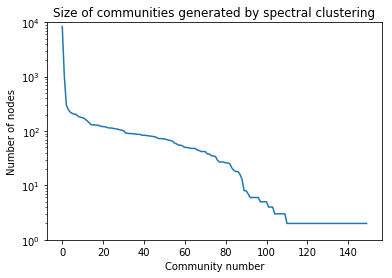

In [36]:
# plots

y_pos = []
x_labels = []
for comm2 in communities2:
    if comm2 == -1: continue
    y_pos.append(len(post_df2[post_df_w_comm2["Community"] == comm2]))
#     x_labels.append("{}: {}".format(comm, community_labels[comm]))
    x_labels.append(community_labels[comm2])

y_pos, x_labels = zip(*sorted(zip(y_pos, x_labels), reverse=True))

plt.plot(y_pos)
plt.title("Size of communities generated by spectral clustering")
plt.ylabel("Number of nodes")
plt.yscale('log')
plt.ylim((1,10000))
plt.xlabel("Community number")
plt.savefig('spec_community_size.png')

In [37]:
communities2

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149}

In [38]:
y_pos = []
x_labels = []
for comm2 in communities2:
    if comm2 == -1: continue
    y_pos.append(len(post_df2[post_df_w_comm2["Community"] == comm2]))
#     x_labels.append("{}: {}".format(comm, community_labels[comm]))
    x_labels.append(community_labels[comm2])

y_pos, x_labels = zip(*sorted(zip(y_pos, x_labels), reverse=True))

print y_pos

(8343, 1037, 301, 246, 222, 210, 206, 200, 184, 180, 175, 169, 156, 145, 132, 130, 130, 128, 127, 122, 121, 120, 116, 114, 114, 112, 110, 109, 106, 104, 102, 92, 91, 90, 90, 89, 88, 87, 87, 84, 84, 83, 82, 81, 80, 79, 77, 73, 73, 72, 72, 70, 68, 67, 65, 60, 58, 55, 55, 53, 50, 50, 49, 48, 48, 48, 45, 44, 42, 42, 42, 38, 38, 35, 35, 34, 29, 27, 27, 27, 26, 26, 25, 21, 19, 18, 18, 16, 13, 8, 8, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)


In [39]:
COMM_TEST = 5

print len(post_df[post_df_w_comm["Community"] == COMM_TEST])

post_df[post_df_w_comm["Community"] == COMM_TEST]

97


,post_id,user_id,TopWord1,TopWord2,TopWord3,TopWord4,TopWord5,Community
106,317836,187875,outliers,iqr,attached,articles,learned,5
109,317839,187543,vs age,5th percentile,variable vs,5th,percentile,5
292,318065,172079,data source,bias,source,selection bias,news,5
1348,319427,151724,occupied,occupied past,past occupied,past,bird species,5
1576,319729,189194,en wikipedia,wikipedia org,https en,org wiki,en,5
1639,319809,3382,recorded fixed,fixed intervals,recorded,ambiguous recorded,better define,5
2538,320986,189901,processes,probability statistics,stochastic processes,regression analysis,textbook,5
2953,321502,144089,shrinkage factor,shrinkage,overall shrinkage,multinomial regression,level outcome,5
3144,321747,130324,bias,statistical bias,bias differs,bias quantity,case kinds,5
3148,321751,67791,egreg,past days,rep,se,past,5


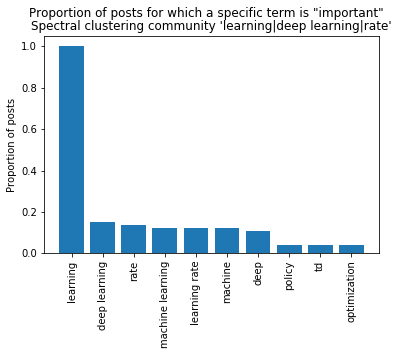

In [62]:
# word frequency in communities2
word_counts2 = collections.defaultdict(dict)
word_freqs2 = collections.defaultdict(dict)
for comm in communities2:
    total_rows = 0.0
    word_counts2[comm] = collections.defaultdict(int)
    for word in post_df_w_comm2[post_df_w_comm2["Community"] == comm]['TopWord1']:
        word_counts2[comm][word] += 1
        total_rows += 1
    for word in post_df_w_comm2[post_df_w_comm2["Community"] == comm]['TopWord2']:
        word_counts2[comm][word] += 1
    for word in post_df_w_comm2[post_df_w_comm2["Community"] == comm]['TopWord3']:
        word_counts2[comm][word] += 1
    for word in post_df_w_comm2[post_df_w_comm2["Community"] == comm]['TopWord4']:
        word_counts2[comm][word] += 1
    for word in post_df_w_comm2[post_df_w_comm2["Community"] == comm]['TopWord5']:
        word_counts2[comm][word] += 1
    for word in word_counts2[comm]:
        word_freqs2[comm][word] = word_counts2[comm][word] / total_rows
    
sorted_word_freqs2 = collections.defaultdict(dict)
for comm in word_freqs2:
    sorted_word_freqs2[comm] = sorted(word_freqs2[comm].items(), key=lambda x: x[1], reverse=True)

COMM_TERMS2 = 64
y_pos = []
x_labels = []
for word in sorted_word_freqs2[COMM_TERMS2][:10]:
    y_pos.append(word[1])
    x_labels.append(word[0])
    
plt.bar(x_labels, y_pos)
plt.xticks(rotation=90)
plt.ylabel("Proportion of posts")
plt.title("Spectral clustering community 'learning|deep learning|rate'")
plt.suptitle('Proportion of posts for which a specific term is "important"')
plt.savefig('spec_proportion.png')

In [66]:
post_df2[post_df_w_comm2["Community"] == 64][1:6][["post_id", "TopWord1", "TopWord2", "TopWord3", "TopWord4", "TopWord5"]].reset_index(drop=True)

,post_id,TopWord1,TopWord2,TopWord3,TopWord4,TopWord5
0,318423,texts,author,learning,author texts,berger extremely
1,319130,hardness,learning,deep learning,deep,non informative
2,319532,principled,science,learning,able technologies,build ships
3,320357,deep learning,multilayer,deep,learning,learning algorithm
4,320803,policy,policy methods,methods,sutton barto,learning


In [68]:
post_df[post_df_w_comm["Community"] == 9][1:6][["post_id", "TopWord1", "TopWord2", "TopWord3", "TopWord4", "TopWord5"]].reset_index(drop=True)

,post_id,TopWord1,TopWord2,TopWord3,TopWord4,TopWord5
0,318082,architecture,reinforcement learning,reinforcement,learning,24x24
1,318311,ordinate,elbow,elbow point,drops,value ordinate
2,318423,texts,author,learning,author texts,berger extremely
3,319061,bus,observe process,having seen,long,minutes
4,319130,hardness,learning,deep learning,deep,non informative


In [72]:
cnm_postids = set(post_df[post_df_w_comm["Community"] == 9]["post_id"])

In [75]:
spectral_postids = set(post_df2[post_df_w_comm2["Community"] == 64]["post_id"])

In [73]:
len(cnm_postids)

127

In [76]:
len(spectral_postids)

73

In [77]:
len(cnm_postids.intersection(spectral_postids))

53